In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi

from scipy.interpolate import interp1d
from scipy.optimize import curve_fit, brentq

import pandas as pd

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'#['dejavusans', 'dejavuserif', 'cm', 'stix', 'stixsans', 'custom']
font = {'family': 'Times New Roman',
        #'color':  'black',
        'weight': 'normal',
        'size': 14,
        }

In [2]:
# import classy module
from classy import Class

In [3]:
# Lambda CDM

common_settings = {'omega_b':0.02300579,
                   'omega_cdm':0.1243789,
                   # '100*theta_s':1.056498,
                   'h':0.7139304,
                   # 'A_s':2.100549e-09,
                   'ln10^{10}A_s':3.024349,
                   'n_s':0.971559,
                   'tau_reio':0.05018996,
                   'N_ur':2.046,
                   'N_ncdm':1,
                   'm_ncdm':0.06,
                   'T_ncdm':0.7137658555036082,
                   'YHe':'BBN',
                   'output':'tCl,pCl,lCl,mPk',
                   'lensing':'yes',
                   'P_k_max_1/Mpc':20.0,
                   'z_max_pk':3,
                   'k_output_values':'1.e-3,1.e-2,0.1,1,10.',
                   'background_verbose':3,
                   'thermodynamics_verbose':3,
                   'input_verbose':5}

In [4]:
LCDM = Class()
LCDM.set(common_settings)
%time
LCDM.compute()

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.29 µs


In [5]:
LCDM.theta_s_100()

1.0564983644681978

In [6]:
# LCDM.empty()

In [7]:
help(LCDM.pk_lin)

Help on built-in function pk_lin:

pk_lin(...) method of classy.Class instance
    Gives the linear total matter pk (in Mpc**3) for a given k (in 1/Mpc) and z
    
    .. note::
    
        there is an additional check that output contains `mPk`,
        because otherwise a segfault will occur



In [8]:
k_arr = np.logspace(-3,1)
z_arr = np.linspace(0,3, 10)

pks = {}
for z in z_arr:
    pks[z] = np.array([LCDM.pk_lin(k, z) for k in k_arr])

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


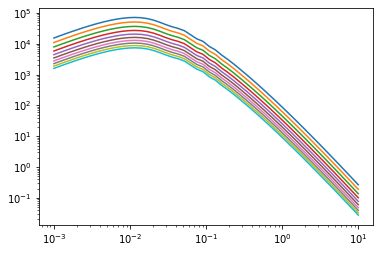

In [9]:
for z in z_arr:
    plt.loglog(k_arr, pks[z])

In [10]:
def k_vel2comov(self, k_vel, z, units='1/Mpc'):
    """
    k : wavenumber in velocity units [s/km]
    z : redshift
    units : units for the output comoving wavenumber, either ('1/Mpc' or 'h/Mpc')
    """
    
    Hz = 100*self.h()*(self.Hubble(z)/self.Hubble(0))
    k_com = k_vel*(Hz/(1+z))
    
    if units == '1/Mpc':
        return k_com
        
    elif units == 'h/Mpc':
        return k_com/self.h()
        
    else:
        raise ValueError("The allowed units for k are '1/Mpc' and 'h/Mpc' only.")

In [11]:
k_vel2comov(LCDM, 0.009, 3, 'h/Mpc')

0.9888285008678015

In [12]:
def pl_fn(k, kp, D, n):
    return D*(k/kp)**(n+3)

def log2_fn(k, tau):
    return (np.log(k*tau))**2

def plateau(k, a, b, g ,d):
    return ((1-d)*(1 + (a*k)**b)**g + d)

def osc_fn(k, kp, A, X, phi):
    return (1 + A*np.sin((k-kp)*X + phi))

def damp_osc_fn(k, kp, A, X, phi, km, sig, p):
    
    # arg1 = -(((k - km)/sig)**2)**(p/2)
    # arg2 = 0*(((kp - km)/sig)**2)**(p/2)
    # arg = arg1 + arg2
    # expo = np.exp(arg)
    
    expo = np.exp(-(np.abs((k - km)/sig)**p))
    expop = np.exp(-(np.abs((kp - km)/sig)**p))
    
    return (1 + A*(expo/expop)*np.sin((k-kp)*X + phi))

In [13]:
def pk_pl(k, kp, D, n):
    
    pl = pl_fn(k, kp, D, n)
    
    return pl

def pk_pl_log(k, kp, D, n, tau):
    
    pl = pl_fn(k, kp, D, n)
    log = log2_fn(k, tau)/log2_fn(kp, tau)
    
    return pl*log

def pk_pl_log_sup(k, kp, D, n, tau, a, b, g, d):
    
    pl = pl_fn(k, kp, D, n)
    log = log2_fn(k, tau)/log2_fn(kp, tau)
    sup = plateau(k, a, b, g, d)# TODO: now D will not be the amplitude at kp!
    
    return pl*log*sup

def pk_pl_log_sup_osc(k, kp, D, n, tau, a, b, g, d, A, X, phi):
    
    pl = pl_fn(k, kp, D, n)
    log = log2_fn(k, tau)/log2_fn(kp, tau)
    sup = plateau(k, a, b, g, d)# TODO: now D will not be the amplitude at kp!
    osc = osc_fn(k, kp, A, X, phi)
    
    return pl*log*sup*osc

def pk_pl_log_sup_damposc(k, kp, D, n, tau, a, b, g, d, A, X, phi, km, sig, p):
    
    pl = pl_fn(k, kp, D, n)
    log = log2_fn(k, tau)/log2_fn(kp, tau)
    sup = plateau(k, a, b, g, d)# TODO: now D will not be the amplitude at kp!
    damposc = damp_osc_fn(k, kp, A, X, phi, km, sig, p)
    
    return pl*log*sup*damposc

# def pk_fit_pl(k, D, n, kstar):
#     return np.log10(D) + n*np.log10(k/kstar)

# def pk_fit_osc(k, D, n, kstar, X, phi):
#     # return np.log10(D) + n*np.log10(k/kstar)
#     return pk_fit_pl(k, D, n) + np.log10(np.sin(k*X + phi))

In [14]:
def zeros(fn, arr, *args):
    """
    Find where a function crosses 0. Returns the zeroes of the function.

    Parameters
    ----------
    fn : function
    arr : array of arguments for function
    *args : any other arguments the function may have
    """

    # the reduced function, with only the argument to be solved for (all other arguments fixed):
    def fn_reduced(array): return fn(array, *args)

    # the array of values of the function:
    fn_arr = fn_reduced(arr)

    # looking where the function changes sign...
    sign_change_arr = np.where(np.logical_or((fn_arr[:-1] < 0.) * (fn_arr[1:] > 0.),
                                             (fn_arr[:-1] > 0.) * (fn_arr[1:] < 0.))
                               )[0]

    # or, just in case, where it is exactly 0!
    exact_zeros_arr = np.where(fn_arr == 0.)[0]

    # defining the array of 0-crossings:
    cross_arr = []

    # first, interpolating between the sign changes
    if len(sign_change_arr) > 0:
        for i in range(len(sign_change_arr)):
            cross_arr.append(
                brentq(fn_reduced, arr[sign_change_arr[i]],
                       arr[sign_change_arr[i] + 1])
            )

    # and then adding those places where it is exactly 0
    if len(exact_zeros_arr) > 0:
        for i in range(len(exact_zeros_arr)):
            cross_arr.append(arr[exact_zeros_arr[i]])

    # sorting the crossings in increasing order:
    cross_arr = np.sort(np.array(cross_arr))

    return cross_arr

In [15]:
def find_pk_fit(self, kbounds, kstar, zstar, model='power_law', Npts=201):
    """
    kbounds : [s/km]
    kstar : [s/km]
    zstar : 
    model : ('power_law', 'power_law_sup', or 'power_law_sine')
    """
    
    # TODO: self is argument here, fix!
    k_lo = k_vel2comov(self, kbounds[0], zstar, units='1/Mpc') # TODO: check: conversion at zstar!
    k_hi = k_vel2comov(self, kbounds[1], zstar, units='1/Mpc') # TODO: check: conversion at zstar!
    k_pivot = k_vel2comov(self, kstar, zstar, units='1/Mpc')
    
    k_arr = np.logspace(np.log10(k_lo), np.log10(k_hi), Npts)
    pk_arr = np.array([self.pk_lin(k, zstar) for k in k_arr])
    dpk_arr = (k_arr**3)*pk_arr / (2. * np.pi**2.)
    
    if model == 'power_law':
        
        def to_fit(Lk, D, n):
            return np.log10(pk_pl(10**Lk, k_pivot, D, n))
        
        pars, _ = curve_fit(to_fit, np.log10(k_arr), np.log10(dpk_arr), [0.3, -2.3], maxfev=50000)
        
        return pars
    
    if model == 'power_law_log':
        
        teq = self.tau_eq()
        
        def to_fit(Lk, D, n, ft):
            return np.log10(pk_pl_log(10**Lk, k_pivot, D, n, (10**ft)*teq))
        
        pars, _ = curve_fit(to_fit, np.log10(k_arr), np.log10(dpk_arr), [0.3, -2.3, 0], bounds=([0, -5, -2], [10, 5, 2]), maxfev=50000)
        
        # rescaling dimensionful parameters
        pars[2] = (10**pars[2])*teq
        
        return pars
    
    elif model == 'power_law_log_sup':
        
        teq = self.tau_eq()
        tau_drag_twin = self.tau_d_twin()
        delta = 1.-2.*self.r_all_twin()
        
        def to_fit(Lk, D, n, ft, fa, b, g, d):
            return np.log10(pk_pl_log_sup(10**Lk, k_pivot, D, n, (10**ft)*teq, (10**fa)*tau_drag_twin, b, g, d))
        
        # D, n, tau, a, b, g, d
        ref_vals = [0.3, -2.3, 0, 0, 1, -1, delta]
        lower_bounds = [0, -5, -2, -3, 0, -10, 0]
        upper_bounds = [10, 5, 2, 3, 10, 0, 1]
        
        pars, _ = curve_fit(to_fit, np.log10(k_arr), np.log10(dpk_arr), ref_vals, bounds=(lower_bounds, upper_bounds), maxfev=50000)
        
        # rescaling dimensionful parameters
        pars[2] = (10**pars[2])*teq
        pars[3] = (10**pars[3])*tau_drag_twin
        
        return pars
        
    
    elif model == 'power_law_log_sup_sine':
        
        teq = self.tau_eq()
        tau_drag_twin = self.tau_d_twin()
        delta = 1.-2.*self.r_all_twin()
        
        # fitting first to the spectrum without oscillations, in order to get a good guess
        def to_fit(Lk, D, n, ft, fa, b, g, d):
            return np.log10(pk_pl_log_sup(10**Lk, k_pivot, D, n, (10**ft)*teq, (10**fa)*tau_drag_twin, b, g, d))
        
        # D, n, tau, a, b, g, d
        ref_vals = [0.3, -2.3, 0, 0, 1, -1, delta]
        lower_bounds = [0, -5, -2, -3, 0, -10, 0]
        upper_bounds = [10, 5, 2, 3, 10, 0, 1]
        
        pars1, _ = curve_fit(to_fit, np.log10(k_arr), np.log10(dpk_arr), ref_vals, bounds=(lower_bounds, upper_bounds), maxfev=50000)
        
        # defining new y-array, only oscillations
        new_yarr = dpk_arr/(10**to_fit(np.log10(k_arr), *pars1))
        
        # interpolation of oscillations
        def yosc(k):
            temp_fn = interp1d(np.log10(k_arr), new_yarr - 1)
            return temp_fn(np.log10(k))
        
        # estimate of frequency
        X_guess = 2.*np.pi/(2*np.mean(np.diff(zeros(yosc, k_arr))))
        
        # print(zeros(yosc, k_arr))
        # print(np.diff(zeros(yosc, k_arr)))
        # print(2*np.mean(np.diff(zeros(yosc, k_arr))))
        # print(X_guess)
        
        
        # print(pars1)
        # print(new_yarr)
        
        # defining new function, with oscillations
        def to_fit(Lk, A, X, phi):
            return osc_fn((10**Lk), k_pivot, A, X, phi)
        
        
        # A, X, phi
        ref_vals = [max(np.abs(new_yarr - 1)), X_guess, np.pi]
        lower_bounds = [0, 0.01*X_guess, 0]
        upper_bounds = [1, 100*X_guess, 2.*np.pi]
        
        pars2, _ = curve_fit(to_fit, np.log10(k_arr), new_yarr, ref_vals, bounds=(lower_bounds, upper_bounds))
        
        pars = np.concatenate([pars1, pars2])
        
        # rescaling dimensionful parameters
        pars[2] = (10**pars[2])*teq
        pars[3] = (10**pars[3])*tau_drag_twin
        # pars[8] = (10**pars[8])*tau_drag_twin/np.sqrt(3)
        # pars[8] *= tau_drag_twin
        
        return pars
    
    elif model == 'power_law_log_sup_dampsine':
        
        teq = self.tau_eq()
        tau_drag_twin = self.tau_d_twin()
        delta = 1.-2.*self.r_all_twin()
        
        # fitting first to the spectrum without oscillations, in order to get a good guess
        def to_fit(Lk, D, n, ft, fa, b, g, d):
            return np.log10(pk_pl_log_sup(10**Lk, k_pivot, D, n, (10**ft)*teq, (10**fa)*tau_drag_twin, b, g, d))
        
        # D, n, tau, a, b, g, d
        ref_vals = [0.3, -2.3, 0, 0, 1, -1, delta]
        lower_bounds = [0, -5, -2, -3, 0, -10, 0]
        upper_bounds = [10, 5, 2, 3, 10, 0, 1]
        
        pars1, _ = curve_fit(to_fit, np.log10(k_arr), np.log10(dpk_arr), ref_vals, bounds=(lower_bounds, upper_bounds), maxfev=50000)
        
        # defining new y-array, only oscillations
        new_yarr = dpk_arr/(10**to_fit(np.log10(k_arr), *pars1))
        
        # interpolation of oscillations
        def yosc(k):
            temp_fn = interp1d(np.log10(k_arr), new_yarr - 1)    
            return temp_fn(np.log10(k))
        
        # estimate of frequency
        X_guess = 2.*np.pi/(2*np.mean(np.diff(zeros(yosc, k_arr))))
        
        # print(zeros(yosc, k_arr))
        # print(np.diff(zeros(yosc, k_arr)))
        # print(2*np.mean(np.diff(zeros(yosc, k_arr))))
        # print(X_guess)
        
        # print(pars1)
        # print(new_yarr)
        
        # defining new function, with oscillations
        def to_fit(Lk, A, X, phi, fk, fs, p):
            
            # print(fk, fs)
            # print((10**fk)*(1/tau_drag_twin), (10**fs)*(1/tau_drag_twin))
            # print(np.exp(-(((10**Lk - (10**fk)*(1/tau_drag_twin))/(10**fs)*(1/tau_drag_twin))**2)**(2/2) + (((k_pivot - (10**fk)*(1/tau_drag_twin))/(10**fs)*(1/tau_drag_twin))**2)**(2/2)))
            
            return damp_osc_fn((10**Lk), k_pivot, A, X, phi, (10**fk)/tau_drag_twin, (10**fs)/tau_drag_twin, p)
        
        # A, X, phi, km, sigma, p
        ref_vals = [max(np.abs(new_yarr - 1)), X_guess, np.pi, 0, 0, 2]
        lower_bounds = [0, 0.01*X_guess, 0, -2, -2, 0.5]
        upper_bounds = [1, 100.*X_guess, 2.*np.pi, 2, 2, 4]
        
        pars2, _ = curve_fit(to_fit, np.log10(k_arr), new_yarr, ref_vals, bounds=(lower_bounds, upper_bounds))
        
        pars = np.concatenate([pars1, pars2])
        
        # rescaling dimensionful parameters
        pars[2] = (10**pars[2])*teq
        pars[3] = (10**pars[3])*tau_drag_twin
        # pars[8] = (10**pars[8])*tau_drag_twin/np.sqrt(3)
        pars[10] = (10**pars[10])/tau_drag_twin
        pars[11] = (10**pars[11])/tau_drag_twin
        
        return pars
    
    else:
        raise ValueError("The only models allowed are 'power_law', 'power_law_log', 'power_law_log_sup', 'power_law_log_sup_sine', and 'power_law_log_sup_dampsine'.")
    

In [26]:
def Dn_raw(self, kbounds, kstar, zstar, Npts=201):
    
    # k limits and pivot
    k_lo = k_vel2comov(self, kbounds[0], zstar, units='1/Mpc') # TODO: check: conversion at zstar!
    k_hi = k_vel2comov(self, kbounds[1], zstar, units='1/Mpc') # TODO: check: conversion at zstar!
    k_pivot = k_vel2comov(self, kstar, zstar, units='1/Mpc')
    
    # k array
    k_arr = np.logspace(np.log10(k_lo), np.log10(k_hi), Npts)
    
    # power spectrum and dimless power spectrum
    pk_arr = np.array([self.pk_lin(k, zstar) for k in k_arr])
    dpk_arr = (k_arr**3)*pk_arr / (2. * np.pi**2.)
    
    # dimless power spectrum function
    def dpk(k): return 10.**(interp1d(np.log10(k_arr), np.log10(dpk_arr))(np.log10(k)))
    
    # power-law
    n_arr = (k_arr*np.gradient(dpk(k_arr), k_arr)/dpk(k_arr) - 3)
    
    # amplitude and power-law
    Draw = float(dpk(k_pivot))
    nraw = float(interp1d(np.log10(k_arr), n_arr)(np.log10(k_pivot)))
    
    return (Draw, nraw)

In [27]:
klo, kp0, khi = k_vel2comov(LCDM, 0.001, 3), k_vel2comov(LCDM, 0.009, 3), k_vel2comov(LCDM, 0.08, 3)
print(klo, kp0, khi)

0.07843941412843888 0.7059547271559499 6.275153130275111


In [28]:
LCDM.Dn_pivot([0.001, 0.08], 0.009, 3, model='power_law_log')

(0.36253299383350385, -2.3098032608879016)

In [29]:
D0, n0 = kp0**3 * LCDM.pk_lin(kp0, 3)/ (2. * np.pi**2.), LCDM.pk_tilt(kp0, 3)
print(D0, n0)

0.3682429849513802 -2.2944373729928125


In [33]:
Dn_raw(LCDM, [0.001, 0.08], 0.009, 3, Npts=201)

(0.3682391430247165, -2.2949603178976257)

In [31]:
fitslog = find_pk_fit(LCDM, [0.001, 0.08], 0.009, 3, model='power_law_log')
print(fitslog)

D1 = pk_pl_log(kp0, kp0, *fitslog)
n1 = (k_arr*np.gradient(pk_pl_log(k_arr, kp0, *fitslog), k_arr)/pk_pl_log(k_arr, kp0, *fitslog) - 3)
n1 = interp1d(np.log10(k_arr), n1)(np.log10(kp0))

print(D1, n1)

[ 0.36253298 -2.90842647 40.02403879]
0.3625329781909397 -2.3090098752130097


In [20]:
k_arr = np.logspace(np.log10(klo), np.log10(khi))
pk_arr = np.array([LCDM.pk_lin(k, 3) for k in k_arr])
dpk_arr = (k_arr**3)*pk_arr / (2. * np.pi**2.)
keq = 1./LCDM.tau_eq()

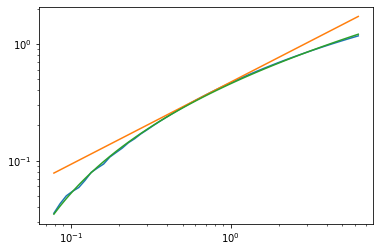

In [21]:
plt.loglog(k_arr, dpk_arr)
plt.loglog(k_arr, (pk_pl(k_arr, kp0, D0, n0)))
plt.loglog(k_arr, (pk_pl_log(k_arr, kp0, *fitslog)))

(0.9, 1.1)

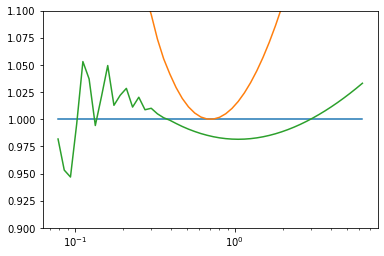

In [36]:
plt.plot(k_arr, dpk_arr/dpk_arr)
plt.plot(k_arr, (pk_pl(k_arr, kp0, D0, n0))/dpk_arr)
plt.plot(k_arr, (pk_pl_log(k_arr, kp0, *fitslog))/dpk_arr)
plt.xscale('log')
plt.ylim(0.9,1.1)

In [29]:
klo, kp0, khi = k_vel2comov(LCDM, 0.001, 3), k_vel2comov(LCDM, 0.009, 3), k_vel2comov(LCDM, 0.08, 3)

klo, kp0, khi

(0.07843941412843888, 0.7059547271559499, 6.275153130275111)

In [1]:
0.07843941412843888/0.7

0.11205630589776984

In [2]:
6.275153130275111/0.7

8.964504471821588

In [32]:
k_arr = np.logspace(np.log10(klo), np.log10(khi), 201)

pk_arr = np.array([LCDM.pk_lin(k, 3) for k in k_arr])
dpk_arr = (k_arr**3)*pk_arr / (2. * np.pi**2.)

del pk_arr

In [37]:
np.argmin(np.abs(k_arr - kp0))

100

In [49]:
kp0

0.7059547271559499

In [45]:
k_arr[99:102], dpk_arr[99:102]

(array([0.68637884, 0.70158345, 0.71712487]),
 array([0.36098365, 0.36663249, 0.3723314 ]))

In [15]:
Dn_raw(LCDM, [0.001, 0.08], 0.009, 3)

(0.3682391430247165, -2.2949603178976257)

In [4]:
# nuADAM
# adam_settings = {'omega_b':0.0223828,
#                  # 'omega_dm_tot':0.1201075,
#                  'omega_cdm':0.1101075,
#                  # '100*theta_s':1.04179712,
#                  'h':0.67,
#                  'A_s':2.100549e-09,'n_s':0.9660499,'tau_reio':0.05430842,
#                  'N_ur':2.046,'N_ncdm':1,'m_ncdm':0.06,'T_ncdm':0.7137658555036082,'YHe':'BBN',
#                  'output':'tCl,pCl,lCl,mPk','lensing':'yes','P_k_max_1/Mpc':20.0,'z_max_pk':3,
#                  'YHe_twin':0.0,
#                  'm_p_dark':1.,
#                  'log10_alphafs_dark':-2.0,
#                  'dof_extra_twin':10.5,
#                  'log10_me_mp_dark_ratio':-3.,
#                  'Delta_N_twin':0.5,
#                  'r_all_twin':0.2,
#                  'background_verbose':2,
#                  'thermodynamics_verbose':2
#                 }

# Fail-point #1
# new_adam_settings = {'YHe_twin':0.0,
#                      'm_p_dark':1.,
#                      'log10_alphafs_dark':-2.0,
#                      'dof_extra_twin':10.5,
#                      'log10_me_mp_dark_ratio':-0.8881274,
#                      'Delta_N_twin':0.4432684,
#                      'r_all_twin':0.03070921,
#                      'background_verbose':2,
#                      'thermodynamics_verbose':2
#                     }

# Fail-point #2
new_adam_settings = {'YHe_twin':0.0,
                     'm_p_dark':1.,
                     'log10_alphafs_dark':-2.0,
                     'dof_extra_twin':10.5,
                     'log10_me_mp_dark_ratio':-2.318476,
                     'Delta_N_twin':0.4978077,
                     'r_all_twin':0.02857489,
                     'background_verbose':3,
                     'thermodynamics_verbose':3,
                     'input_verbose':3
                    }

adam_settings = dict(common_settings, **new_adam_settings)

In [5]:
ADAM = Class()
ADAM.set(adam_settings)
ADAM.compute()

In [19]:
ADAM.r_all_twin()

0.02857489

In [20]:
ADAM.tau_eq()

109.82091795294744

In [21]:
klo, kp0, khi = k_vel2comov(ADAM, 0.001, 3), k_vel2comov(ADAM, 0.009, 3), k_vel2comov(ADAM, 0.08, 3)
print(klo, kp0, khi)

0.07935519505062763 0.7141967554556486 6.34841560405021


In [22]:
# D, n, tau, a, b, g, d, A, X, phi, km, sigma, p

fits1 = find_pk_fit(ADAM, [0.001, 0.08], 0.009, 3, model='power_law_log_sup')
fits2 = find_pk_fit(ADAM, [0.001, 0.08], 0.009, 3, model='power_law_log_sup_sine')
fits3 = find_pk_fit(ADAM, [0.001, 0.08], 0.009, 3, model='power_law_log_sup_dampsine')

print('D, n, tau, a, b, g, d:\n', fits1)
print('D, n, tau, a, b, g, d, A, X, phi:\n', fits2)
print('D, n, tau, a, b, g, d, A, X, phi, km, sigma, p:\n', fits3)

D, n, tau, a, b, g, d:
 [ 0.33316558 -2.90862037 42.80702446  0.21980749  9.99926063 -7.49214354
  0.96557501]
D, n, tau, a, b, g, d, A, X, phi:
 [ 3.33165584e-01 -2.90862037e+00  4.28070245e+01  2.19807491e-01
  9.99926063e+00 -7.49214354e+00  9.65575009e-01  7.76293462e-03
  7.60324833e+00  3.49935886e+00]
D, n, tau, a, b, g, d, A, X, phi, km, sigma, p:
 [ 3.33165584e-01 -2.90862037e+00  4.28070245e+01  2.19807491e-01
  9.99926063e+00 -7.49214354e+00  9.65575009e-01  2.34062676e-02
  4.08337957e+00  3.61754404e+00  3.74708996e+00  2.90174559e+00
  4.00000000e+00]


In [23]:
2.73181630e+01/ADAM.tau_eq() * np.pi

0.7814771701975666

In [24]:
ADAM.pk_tilt(0.6925923786763194, 3)

-2.4273416348173775

In [25]:
ADAM.tau_d_twin()/np.sqrt(3)

5.41198860302834

In [26]:
k_arr = np.logspace(np.log10(klo), np.log10(khi), 501)
pk_arr = np.array([ADAM.pk_lin(k, 3) for k in k_arr])
dpk_arr = (k_arr**3)*pk_arr / (2. * np.pi**2.)

pk0_arr = np.array([LCDM.pk_lin(k, 3) for k in k_arr])
dpk0_arr = (k_arr**3)*pk0_arr / (2. * np.pi**2.)

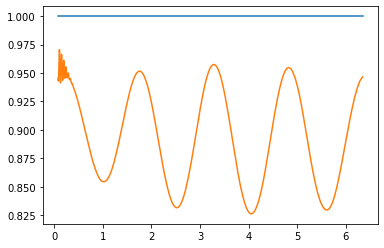

In [27]:
plt.plot(k_arr, dpk0_arr/dpk0_arr)
plt.plot(k_arr, dpk_arr/dpk0_arr)

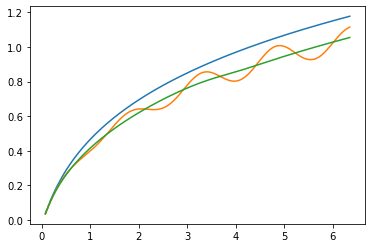

In [28]:
# Aor = fits2[-3]
# Xor = fits2[-2]
# For = fits2[-1]

# fits2[-3] *= 7
# fits2[-2] *= 0.5
# fits2[-1] = np.pi/1.2

plt.plot(k_arr, dpk0_arr)
plt.plot(k_arr, dpk_arr)
plt.plot(k_arr, (pk_pl_log_sup(k_arr, kp0, *fits1)))
# plt.plot(k_arr, (pk_pl_log_sup_osc(k_arr, kp0, *fits2)))
# plt.plot(k_arr, (pk_pl_log_sup_damposc(k_arr, kp0, *fits3)))

# plt.plot(k_arr, (pk_pl_log_sup(k_arr, kp0, *fits2[:-3])))
# plt.plot(k_arr, (pk_pl_log_sup(k_arr, kp0, *fits2[:-3]))/osc_fn(kp0, kp0, *fits2[-3:]))

# fits2[-3] = Aor
# fits2[-2] = Xor
# fits2[-1] = For

In [30]:
LCDM.Dn_pivot([0.001, 0.08], 0.009, 3, model='power_law_log')

(0.36253296852582517, -2.3098032467610086)

In [29]:
ADAM.Dn_pivot([0.001, 0.08], 0.009, 3, model='power_law_log_sup')

(0.3337430557090603, -2.319411414110133)

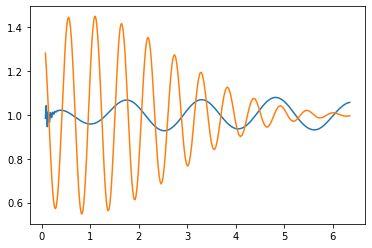

In [38]:
# plt.plot(k_arr, dpk_arr)
plt.plot(k_arr, dpk_arr/(pk_pl_log_sup(k_arr, kp0, *fits1)))
plt.plot(k_arr, damp_osc_fn(k_arr, kp0, 0.45, 11.5, 3.4, 0.9, 2.6, 2))

# plt.plot(k_arr, damp_osc_fn(k_arr, kp0, *fits2[-6:]))
# plt.xlim(0.99*kp0,1.01*kp0)

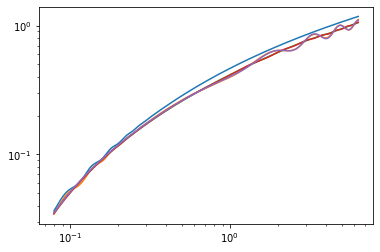

In [39]:
plt.loglog(k_arr, dpk0_arr)
plt.loglog(k_arr, dpk_arr)
plt.loglog(k_arr, (pk_pl_log_sup(k_arr, kp0, *fits1)))
plt.loglog(k_arr, (pk_pl_log_sup_osc(k_arr, kp0, *fits2)))
plt.loglog(k_arr, (pk_pl_log_sup_damposc(k_arr, kp0, *fits3)))

In [40]:
neff0_arr = (k_arr*np.gradient(pk_pl_log(k_arr, kp0, *fitslog), k_arr)/pk_pl_log(k_arr, kp0, *fitslog) - 3)
neff1_arr = (k_arr*np.gradient(pk_pl_log_sup(k_arr, kp0, *fits1), k_arr)/pk_pl_log_sup(k_arr, kp0, *fits1) - 3)
neff2_arr = (k_arr*np.gradient(pk_pl_log_sup(k_arr, kp0, *fits2[:-5]), k_arr)/pk_pl_log_sup(k_arr, kp0, *fits2[:-5]) - 3)
neff3_arr = (k_arr*np.gradient(pk_pl_log_sup_damposc(k_arr, kp0, *fits2), k_arr)/pk_pl_log_sup_damposc(k_arr, kp0, *fits2) - 3)

plt.plot(k_arr, (neff0_arr))
plt.plot(k_arr, (neff1_arr))
plt.plot(k_arr, (neff2_arr))
plt.plot(k_arr, (neff3_arr))
plt.xscale('log')
plt.ylim(-2.6,-2.2)

TypeError: pk_pl_log_sup() missing 2 required positional arguments: 'g' and 'd'

In [41]:
neff1_arr = (k_arr*np.gradient(pk_pl_log_sup(k_arr, kp0, *fits1), k_arr)/pk_pl_log_sup(k_arr, kp0, *fits1) - 3)
neff2_arr = (k_arr*np.gradient(pk_pl_log_sup(k_arr, kp0, *fits2[:-5]), k_arr)/pk_pl_log_sup(k_arr, kp0, *fits2[:-5]) - 3)

TypeError: pk_pl_log_sup() missing 2 required positional arguments: 'g' and 'd'

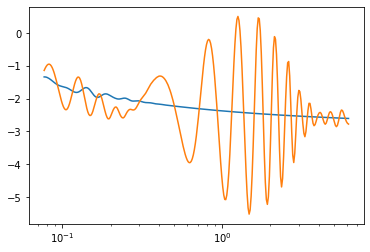

In [73]:
k_arr = np.logspace(np.log10(klo), np.log10(khi), 301)
tilt0_arr = np.array([LCDM.pk_tilt(k, 3) for k in k_arr])
tilt_arr = np.array([ADAM.pk_tilt(k, 3) for k in k_arr])

plt.plot(k_arr, tilt0_arr)
plt.plot(k_arr, tilt_arr)
plt.xscale('log')

TypeError: pk_pl_log_sup_damposc() missing 3 required positional arguments: 'km', 'sig', and 'p'

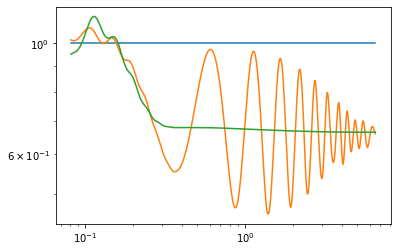

In [38]:
plt.loglog(k_arr, dpk0_arr/dpk0_arr)
plt.loglog(k_arr, dpk_arr/dpk0_arr)
plt.loglog(k_arr, (pk_pl_log_sup(k_arr, kp0, *fits1)/dpk0_arr))
plt.loglog(k_arr, (pk_pl_log_sup_damposc(k_arr, kp0, *fits2)/dpk0_arr))

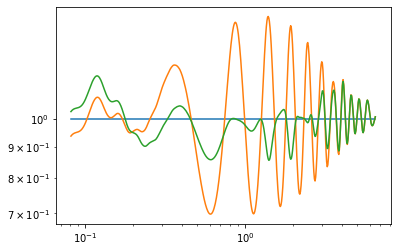

In [138]:
plt.loglog(k_arr, dpk_arr/dpk_arr)
plt.loglog(k_arr, (pk_pl_log_sup(k_arr, kp0, *fits1)/dpk_arr))
plt.loglog(k_arr, (pk_pl_log_sup_damposc(k_arr, kp0, *fits2)/dpk_arr))

In [11]:
# NADA
mp = 1
colors = ['tab:red', 'tab:green', 'tab:blue']
labels = ["10", "100", "1000"]
linestyles = ['-', '--']

dofs = [3.5, 10.5, 21.0]
omega_b = [2.298732e-02, 2.303050e-02, 2.295562e-02]; omega_cdm = [1.081617e-01, 1.072715e-01, 7.997743e-02]
# theta_s = [1.042379e+00, 1.042390e+00, 1.042452e+00];
hs = [0.67, 0.7, 0.73];
ln10A_s = [3.035120e+00, 3.027488e+00, 3.036096e+00]
n_s = [9.743925e-01, 9.741589e-01, 9.752867e-01]; tau_reio = [5.686930e-02, 5.295485e-02, 5.672435e-02]
me_mp = [-2.363930e+00, -2.402628e+00, -2.541104e+00]
Delta_N_twin = [3.988788e-01, 4.874699e-01, 4.248962e-01]; r_all_twin = [1.300764e-01, 1.482534e-01, 3.598236e-01]

{'z_rec_twin': 50485.57169216063, 'z_d_twin': 44800.500429944186}
{'z_rec_twin': 53740.36761460988, 'z_d_twin': 47071.75387736342}
{'z_rec_twin': 45683.290054768906, 'z_d_twin': 42620.99400128978}


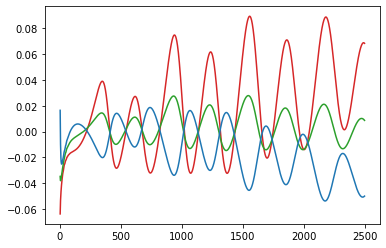

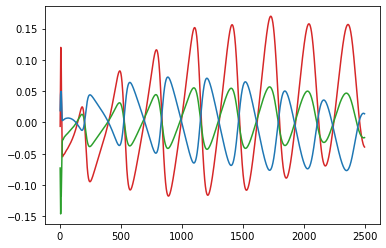

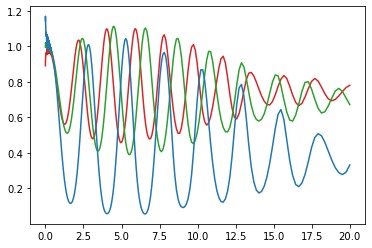

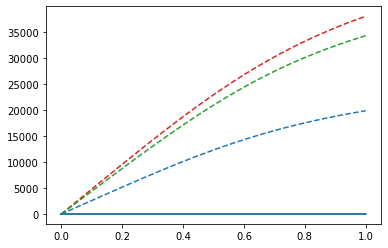

In [10]:
for idx, dof in enumerate(dofs):
    common_settings = {'omega_b':omega_b[idx],'omega_cdm':omega_cdm[idx],
                    #    '100*theta_s':theta_s[idx],
                       'h':hs[idx],
                    'ln10^{10}A_s':ln10A_s[idx],'n_s':n_s[idx],'tau_reio':tau_reio[idx],
                    'N_ur':2.046,'N_ncdm':1,'m_ncdm':0.06,'T_ncdm':0.7137658555036082,'YHe':'BBN',
                    'output':'tCl,pCl,lCl,mPk','lensing':'yes','P_k_max_1/Mpc':20.0}

    params1 = {'YHe_twin':0.0, 'm_p_dark': 1, 'log10_alphafs_dark':-2.0, 'dof_extra_twin':dof}
    params2 = {'log10_me_mp_dark_ratio':me_mp[idx], 'Delta_N_twin':Delta_N_twin[idx], 'r_all_twin':r_all_twin[idx]}

    ADAM = Class()
    ADAM.set(common_settings)
    ADAM.set(params1)
    ADAM.set(params2)
    ADAM.set({'k_output_values':1})
    ADAM.compute()
    all_k = ADAM.get_perturbations()
    one_k = all_k['scalar'][0]

    cls = ADAM.lensed_cl(2500)

    derived = ADAM.get_current_derived_parameters(['z_rec_twin', 'z_d_twin'])
    print(derived)

    # plot TT    
    plt.figure(1)
    cl0 = cls_lcdm['tt'][2:]
    cl = cls['tt'][2:]
    plt.plot(ll, (cl-cl0)/cl0, color=colors[idx], linestyle=linestyles[0], label='d.o.f = ' +str(dof))


    # plot EE    
    plt.figure(2)
    cl0 = cls_lcdm['ee'][2:]
    cl = cls['ee'][2:]
    plt.plot(ll, (cl-cl0)/cl0, color=colors[idx], linestyle=linestyles[0], label='d.o.f = ' +str(dof))


    # Plot MPS
    plt.figure(3)
    h = ADAM.h()
    Pk = []
    for k in kk:
        Pk.append(ADAM.pk_lin(k*h,0.)*h**3) # function .pk(k,z)
    plt.plot(kk, np.array(Pk)/np.array(Pk0), color=colors[idx], linestyle=linestyles[0], label='d.o.f = ' +str(dof))

    delta_idr = abs(one_k['delta_idr'])
    delta_idm_dr = abs(one_k['delta_idm_dr'])
    a = one_k['a']
    
    plt.figure(4)
    plt.plot(a, delta_idr, color=colors[idx], linestyle=linestyles[0], label='d.o.f = ' +str(dof))
    plt.plot(a, delta_idm_dr, color=colors[idx], linestyle=linestyles[1])

In [13]:
plt.figure(1)
plt.xlim(2,2500); plt.xscale('log')
plt.ylim(-0.15, 0.15)
plt.legend(loc='best')
# plt.savefig('./plots/residual_TT_bf.pdf')
plt.close()

plt.figure(2)
plt.xlim(2,2500); plt.xscale('log')
plt.ylim(-0.15, 0.15)
plt.legend(loc='best')
# plt.savefig('./plots/residual_EE_bf.pdf')
plt.close()

plt.figure(3)
plt.legend(loc='best')
# plt.savefig('./plots/Pk_bf.pdf')
plt.close()

plt.figure(4)
plt.yscale('log'); plt.xscale('log')
plt.ylabel('$\delta$'); plt.xlabel('a')
plt.legend(loc='best')
# plt.savefig('./plots/delta_bf.pdf')
plt.close()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
